# Notebook de classification du modèle entraîné avec photos rognées
## Adrian Rodriguez
## Projet 7 parcours Ingénieur Machine Learning
[Accès projet git](https://github.com/Adrian1903/Developpez-une-preuve-de-concept)

[Plus d'informations](https://openclassrooms.com/fr/paths/148-ingenieur-machine-learning)

---
# 0. Contexte
Un rapport sur les erreurs de classification des races de chiens a été soumis à l’association de protection des animaux. Dans ce rapport, il est recommandé d’implémenter une solution de détection d’objet pour améliorer la qualité des photos. Cette solution doit isoler l’objet à classifier en procédant à un rognage.
Cette nouvelle méthode fera appel au dernier YOLO, version 4.

## Sources bibliographiques :
* [Papier sur YOLOv4](https://arxiv.org/pdf/2004.10934v1.pdf)
* [Article sur Medium](https://medium.com/@alexeyab84/yolov4-the-most-accurate-real-time-neural-network-on-ms-coco-dataset-73adfd3602fe)
* [Code source](https://github.com/AlexeyAB/darknet)
* [Tutoriel](https://colab.research.google.com/drive/12QusaaRj_lUwCGDvQNfICpa7kA7_a2dE)

## Prototype
* Dataset : [Stanford Dogs Dataset](https://www.kaggle.com/jessicali9530/stanford-dogs-dataset)
* Méthode baseline : [Modèle Xception 2017 (en production)](https://github.com/Adrian1903/Classez-des-images-l-aide-d-algorithmes-de-Deep-Learning/blob/master/dev/04_cnn_transfer_learning.ipynb), [Rapport de classification](https://github.com/Adrian1903/Classez-des-images-l-aide-d-algorithmes-de-Deep-Learning/blob/master/dev/05_classification_report.ipynb)
* Méthode mise en oeuvre :
  * Phase 1 : Intégration et mesure du détecteur d’objet en production
  * Phase 2 : Si résultat de la phase 1 insuffisant, apprentissage du modèle existant avec photos recadrées et mesure des résultats

Ce notebook présente les résultats de classification du modèle Xception entraînés avec les photos rognées. J'évalue également la performance de YOLOv4 par rapport aux annotations portées dans le jeu de données.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default")
import seaborn as sns

import glob
from bs4 import BeautifulSoup
import lxml
import json
import six


from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array

from sklearn.metrics import classification_report

In [2]:
def get_breed(file):
    image = load_img(file, target_size=(299, 299))
    input_array = np.reshape(img_to_array(image), (-1, 299, 299, 3)) / 255

    # Prédiction de la race
    output = model.predict(input_array)
    return class_label.at[output.argmax(axis=-1)[0], 'index']

def get_top3_breeds(model, file):
    image = load_img(file, target_size=(299, 299))
    input_array = np.reshape(img_to_array(image), (-1, 299, 299, 3)) / 255

    # Prédiction de la race
    output = model.predict(input_array)

    df_out = pd.DataFrame(output[0])
    top3_breeds = pd.merge(class_label, df_out, left_index=True, right_index=True).rename(columns={0: 'Probabilité', 'index': 'Race prédite'}).sort_values('Probabilité', ascending=False).head(3)
    return top3_breeds


def get_true_breed(file):
    return file.split('/')[-2]

def get_best_object(df):
  result_df = pd.DataFrame()
  for i in range(len(df.objects)):

    res = pd.DataFrame(df.objects[i], columns=['class_id', 'name', 'relative_coordinates', 'confidence'])
    if res.empty:
      # NaN si aucun objet détecté (la photo ne sera pas recadrée)
      res.loc[0] = np.nan
    else:
      # Sélection du chien avec la meilleure confidence
      res = res[res.name == "dog"].sort_values(by="confidence", ascending=False).head(1).reset_index(drop=True)

      # NaN si aucun chien détecté (la photo ne sera pas recadrée)
      if res.empty:
        res.loc[0] = np.nan
      else:
        # Extraction des coordonnées de recadrage
        coord = pd.DataFrame.from_dict(res.relative_coordinates.loc[0], orient='index').transpose()
        res = pd.merge(res, coord, left_index=True, right_index=True)

    # Ajout dans un df
    result_df = result_df.append(res)

  return result_df.reset_index(drop=True)

def export_png_table(data, col_width=2.2, row_height=0.625, font_size=10,
                     header_color='#7451eb', row_colors=['#f1f1f2', 'w'],
                     edge_color='w', bbox=[0, 0, 1, 1], header_columns=1,
                     ax=None, filename='table.png', **kwargs):
    ax = None
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])
                ) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox,
                         colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])

    fig.savefig(filename, transparent=True)

    return None

---
# 1. Chargement du modèle et des fichiers nécessaires

In [3]:
model = load_model('src/cropped_best_model_Xception_DataAugmentation_120_breeds.hdf5')
class_label = pd.read_csv('src/class_labels.csv')
test_file = pd.read_csv('src/cropped_test_file.csv')

---
# 2. Extraction des prédictions en erreur

In [4]:
print(f'Nous avons {test_file.shape[0]} images de test')

Nous avons 4116 images de test


In [5]:
test_file.uri = test_file.uri.str.replace('../input/cropped-stanford-dogs-dataset/img_crop', 'src/img_crop')

In [6]:
%time test_file["predicted_breeds"] = test_file.uri.apply(lambda x: get_breed(x))
test_file

Wall time: 22min 29s


,uri,breeds,predicted_breeds
0,src/img_crop/Lhasa/n02098413_1355.jpg,Lhasa,Lhasa
1,src/img_crop/English_setter/n02100735_3111.jpg,English_setter,English_setter
2,src/img_crop/komondor/n02105505_1272.jpg,komondor,komondor
3,src/img_crop/Great_Dane/n02109047_7072.jpg,Great_Dane,Great_Dane
4,src/img_crop/keeshond/n02112350_7618.jpg,keeshond,keeshond
...,...,...,...
4111,src/img_crop/komondor/n02105505_1077.jpg,komondor,komondor
4112,src/img_crop/Scotch_terrier/n02097298_508.jpg,Scotch_terrier,Scotch_terrier
4113,src/img_crop/cocker_spaniel/n02102318_3545.jpg,cocker_spaniel,cocker_spaniel
4114,src/img_crop/clumber/n02101556_2604.jpg,clumber,clumber


In [7]:
error_predict = test_file[test_file.breeds != test_file.predicted_breeds]
error_predict.reset_index(drop=True, inplace=True)
error_predict

,uri,breeds,predicted_breeds
0,src/img_crop/Siberian_husky/n02110185_7246.jpg,Siberian_husky,Eskimo_dog
1,src/img_crop/Siberian_husky/n02110185_2593.jpg,Siberian_husky,Eskimo_dog
2,src/img_crop/dhole/n02115913_4336.jpg,dhole,dingo
3,src/img_crop/Lhasa/n02098413_20304.jpg,Lhasa,Shih-Tzu
4,src/img_crop/Siberian_husky/n02110185_712.jpg,Siberian_husky,Eskimo_dog
...,...,...,...
354,src/img_crop/Australian_terrier/n02096294_5531...,Australian_terrier,Yorkshire_terrier
355,src/img_crop/Labrador_retriever/n02099712_221.jpg,Labrador_retriever,Mexican_hairless
356,src/img_crop/Lakeland_terrier/n02095570_4511.jpg,Lakeland_terrier,soft-coated_wheaten_terrier
357,src/img_crop/wire-haired_fox_terrier/n02095314...,wire-haired_fox_terrier,Lakeland_terrier


---
# 3. Etude des prédictions en erreur
## 3-1. Visualisation d'un échantillon d'erreur

Cas n°1


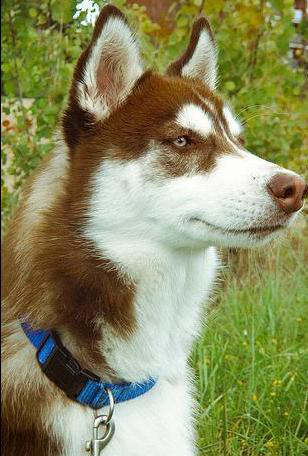

'Race indiquée par les données : Siberian_husky'

,Race prédite,Probabilité
24,Eskimo_dog,0.641019
64,Siberian_husky,0.330398
101,malamute,0.007464


#############################################################

Cas n°2


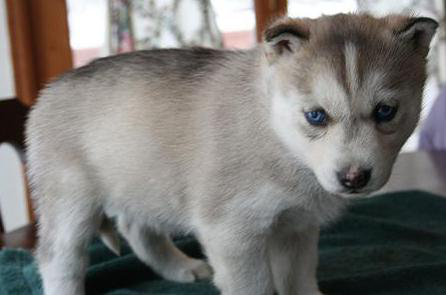

'Race indiquée par les données : Siberian_husky'

,Race prédite,Probabilité
24,Eskimo_dog,0.562865
64,Siberian_husky,0.409635
101,malamute,0.024177


#############################################################

Cas n°3


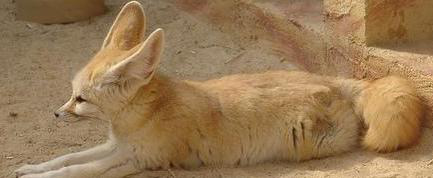

'Race indiquée par les données : dhole'

,Race prédite,Probabilité
92,dingo,0.530664
91,dhole,0.390960
52,Pembroke,0.021145


#############################################################

Cas n°4


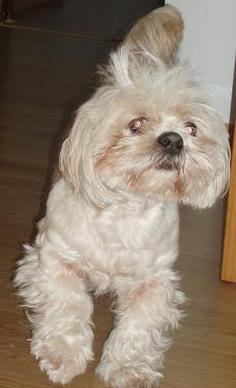

'Race indiquée par les données : Lhasa'

,Race prédite,Probabilité
63,Shih-Tzu,0.569442
43,Lhasa,0.317452
44,Maltese_dog,0.058063


#############################################################

Cas n°5


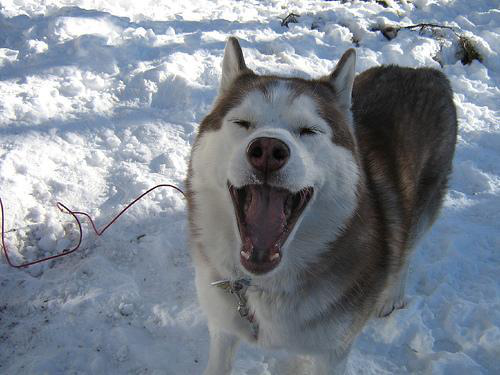

'Race indiquée par les données : Siberian_husky'

,Race prédite,Probabilité
24,Eskimo_dog,0.710461
64,Siberian_husky,0.268738
101,malamute,0.005718


#############################################################

Cas n°6


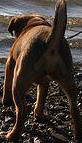

'Race indiquée par les données : Brabancon_griffon'

,Race prédite,Probabilité
82,boxer,0.433387
109,redbone,0.122197
117,vizsla,0.117999


#############################################################

Cas n°7


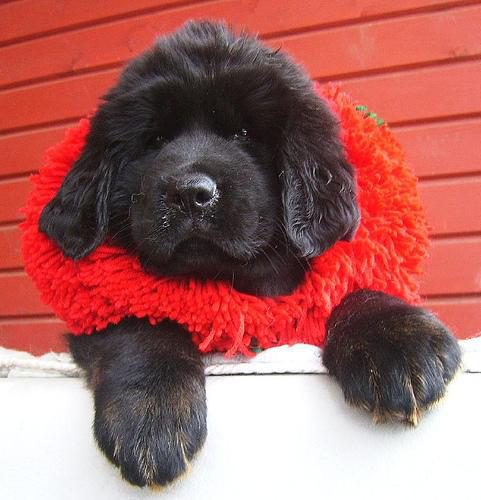

'Race indiquée par les données : Tibetan_mastiff'

,Race prédite,Probabilité
46,Newfoundland,0.902897
67,Tibetan_mastiff,0.087440
93,flat-coated_retriever,0.006488


#############################################################

Cas n°8


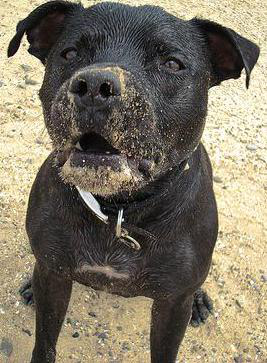

'Race indiquée par les données : American_Staffordshire_terrier'

,Race prédite,Probabilité
65,Staffordshire_bullterrier,0.709105
3,American_Staffordshire_terrier,0.285813
37,Italian_greyhound,0.001523


#############################################################

Cas n°9


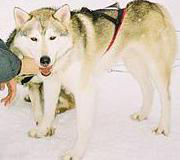

'Race indiquée par les données : Eskimo_dog'

,Race prédite,Probabilité
64,Siberian_husky,0.538842
24,Eskimo_dog,0.450009
101,malamute,0.006090


#############################################################

Cas n°10


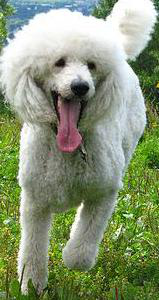

'Race indiquée par les données : standard_poodle'

,Race prédite,Probabilité
104,miniature_poodle,0.433527
113,standard_poodle,0.340419
115,toy_poodle,0.215670


#############################################################

Cas n°11


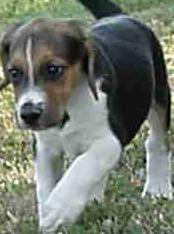

'Race indiquée par les données : English_foxhound'

,Race prédite,Probabilité
77,beagle,0.484307
69,Walker_hound,0.389105
20,English_foxhound,0.113571


#############################################################

Cas n°12


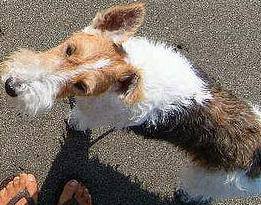

'Race indiquée par les données : Lakeland_terrier'

,Race prédite,Probabilité
119,wire-haired_fox_terrier,0.733794
41,Lakeland_terrier,0.248038
116,toy_terrier,0.003419


#############################################################

Cas n°13


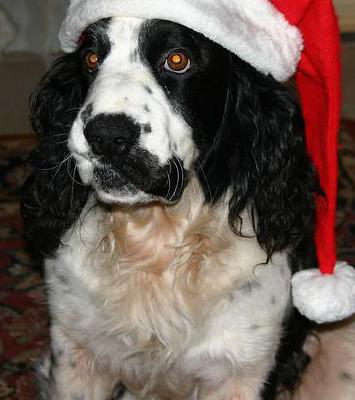

'Race indiquée par les données : English_springer'

,Race prédite,Probabilité
88,cocker_spaniel,0.672492
22,English_springer,0.231912
21,English_setter,0.070425


#############################################################

Cas n°14


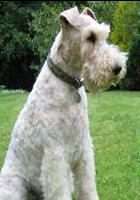

'Race indiquée par les données : wire-haired_fox_terrier'

,Race prédite,Probabilité
41,Lakeland_terrier,0.717008
119,wire-haired_fox_terrier,0.278717
2,Airedale,0.001091


#############################################################

Cas n°15


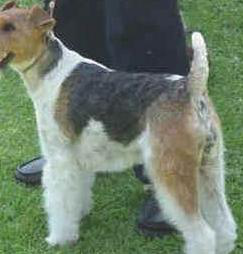

'Race indiquée par les données : wire-haired_fox_terrier'

,Race prédite,Probabilité
41,Lakeland_terrier,0.523132
119,wire-haired_fox_terrier,0.461295
106,otterhound,0.004807


#############################################################

Cas n°16


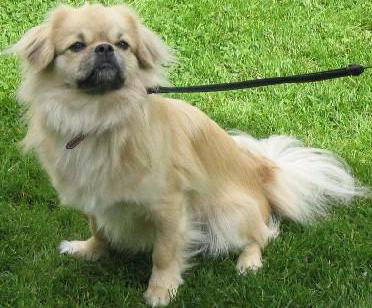

'Race indiquée par les données : Brabancon_griffon'

,Race prédite,Probabilité
51,Pekinese,0.975127
13,Brabancon_griffon,0.015836
53,Pomeranian,0.004960


#############################################################

Cas n°17


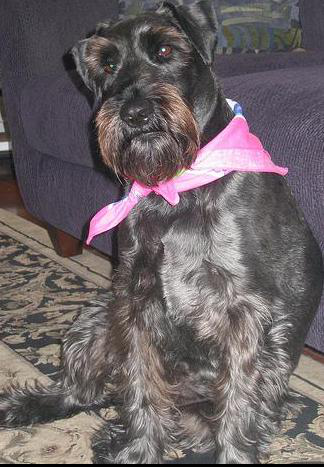

'Race indiquée par les données : standard_schnauzer'

,Race prédite,Probabilité
105,miniature_schnauzer,0.574383
114,standard_schnauzer,0.424880
94,giant_schnauzer,0.000322


#############################################################

Cas n°18


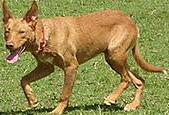

'Race indiquée par les données : kelpie'

,Race prédite,Probabilité
54,Rhodesian_ridgeback,0.253566
98,kelpie,0.236347
92,dingo,0.146088


#############################################################

Cas n°19


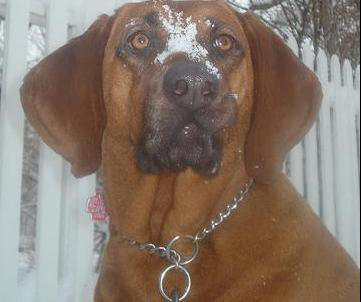

'Race indiquée par les données : redbone'

,Race prédite,Probabilité
117,vizsla,0.518589
109,redbone,0.272700
54,Rhodesian_ridgeback,0.202460


#############################################################

Cas n°20


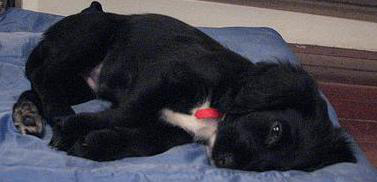

'Race indiquée par les données : cocker_spaniel'

,Race prédite,Probabilité
46,Newfoundland,0.296324
89,collie,0.102446
4,Appenzeller,0.095293


#############################################################



In [8]:
i = 1
for img in error_predict.uri.head(20):
    print(f"Cas n°{i}")
    display(load_img(img))
    display("Race indiquée par les données : " + get_true_breed(img))
    display(get_top3_breeds(model, img))
    print("#############################################################")
    print("")
    i += 1

Les erreurs sont désormais dues à des erreurs d'attribution des races, à des photos de jeunes chiens, ou à des races qui se ressemblent fortement.

---
# 4. Résultat de classification

In [9]:
accuracy_best_model = round((test_file.shape[0] - error_predict.shape[0]) / test_file.shape[0]*100, 1)
print(f'Précision du modèle : {accuracy_best_model} %')

Précision du modèle : 91.3 %


Le modèle entraîné sur les photos rognés donne de meilleurs performance (+4 %).
Recommendations : 
* Fournir un jeu de données propre à l'association,
* Fournir un jeu de données sans erreur d'attribution de races,
* Dans le jeu de données, 1 image = 1 races (Exclure les photos multiraces).
* Essayer un algorithme plus récent.

In [10]:
class_report = classification_report(test_file.breeds, test_file.predicted_breeds, output_dict=True)
class_report_df = pd.DataFrame.from_dict(class_report, orient='columns').transpose().head(-3)
pd.set_option('display.max_rows', None)
class_report_df.sort_values('precision')

,precision,recall,f1-score,support
Eskimo_dog,0.486486,0.642857,0.553846,28.0
miniature_poodle,0.666667,0.880000,0.758621,25.0
Border_collie,0.666667,0.965517,0.788732,29.0
Siberian_husky,0.689655,0.500000,0.579710,40.0
Lakeland_terrier,0.718750,0.958333,0.821429,48.0
American_Staffordshire_terrier,0.724138,0.750000,0.736842,28.0
Norfolk_terrier,0.729730,0.964286,0.830769,28.0
Irish_wolfhound,0.739130,0.971429,0.839506,35.0
EntleBucher,0.750000,0.916667,0.825000,36.0
standard_schnauzer,0.750000,0.777778,0.763636,27.0


# 4. Evaluation de la performance de YOLOv4
## 4-1. Récupération des box du jeu de données

In [11]:
path_annot = "src/annot/"

annot_row = {}
results = pd.DataFrame()

# Extraction des données
for file in glob.glob(path_annot + '*/*'):
  with open(file, "r") as file:
    # Read each line in the file, readlines() returns a list of lines
    content = file.readlines()
    # Combine the lines in the list into a string
    content = "".join(content)
    bs_content = BeautifulSoup(content, "lxml")


    annot_row['filename'] = bs_content.find('filename').string + '.jpg'
    annot_row['width'] = bs_content.find('width').string
    annot_row['height'] = bs_content.find('height').string
    annot_row['annot_xmin'] = bs_content.find('xmin').string
    annot_row['annot_ymin'] = bs_content.find('ymin').string
    annot_row['annot_xmax'] = bs_content.find('xmax').string
    annot_row['annot_ymax'] = bs_content.find('ymax').string
    
    annot_row = pd.Series(annot_row)
    results = results.append(annot_row, ignore_index=True)

# Conversion des obetc en integer
col = ['height', 'width', 'annot_xmax', 'annot_xmin', 'annot_ymax', 'annot_ymin']
results[col] = results[col].astype(int)

## 4-2. Récupération des box YOLOv4

In [12]:
# Conversion des résultats JSON du YOLOv4 en dataframe
jsondata = json.load(open('src/result_yolo_full.json'))
yolo_result = pd.DataFrame(jsondata)
yolo_result.filename = yolo_result.filename.str.split('/').str.get(13)

# Récupération du chien le plus pertinent sur une image, selon YOLOv4
best_object = get_best_object(yolo_result)
yolo_result = pd.merge(yolo_result, best_object, left_index=True, right_index=True)
yolo_result = yolo_result[['filename', 'center_x', 'center_y', 'width', 'height']]

# Si aucun chien n'a été trouvé, valeur = 0
yolo_result = yolo_result.fillna(0)
yolo_result = yolo_result.rename(columns={'center_x': 'yolo_center_x','center_y': 'yolo_center_y','width': 'yolo_width','height': 'yolo_height'})
yolo_result.head()

,filename,yolo_center_x,yolo_center_y,yolo_width,yolo_height
0,n02085620_10074.jpg,0.455568,0.489279,0.804954,1.057105
1,n02085620_10131.jpg,0.548339,0.504275,0.855886,0.966300
2,n02085620_10621.jpg,0.482755,0.502806,0.389775,0.703651
3,n02085620_1073.jpg,0.488581,0.530515,0.992405,0.990712
4,n02085620_10976.jpg,0.517973,0.559173,0.490166,0.733000


## 4-3. Evaluation de YOLOv4
### 4-3-1. Métriques maison (Center, Shape, Global)

In [13]:
# Calcul des coordonnées relatives
results_custom = results.copy()
results_custom['annot_center_x'] = ((results_custom['annot_xmax'] - results_custom['annot_xmin']) / 2 + results_custom['annot_xmin'] ) / results_custom['width']
results_custom['annot_center_y'] = ((results_custom['annot_ymax'] - results_custom['annot_ymin']) / 2 + results_custom['annot_ymin'] ) / results_custom['height']
results_custom['annot_width'] = (results_custom['annot_xmax'] - results_custom['annot_xmin']) / results_custom['width']
results_custom['annot_height'] = (results_custom['annot_ymax'] - results_custom['annot_ymin']) / results_custom['height']
results_custom = results_custom[['filename', 'annot_center_x', 'annot_center_y', 'annot_width', 'annot_height']]
results_custom.head()

,filename,annot_center_x,annot_center_y,annot_width,annot_height
0,n02085620_10074.jpg,0.451952,0.508000,0.753754,0.976000
1,n02085620_10131.jpg,0.559494,0.507071,0.870886,0.977778
2,n02085620_10621.jpg,0.477000,0.491611,0.386000,0.694631
3,n02085620_1073.jpg,0.452174,0.525000,0.904348,0.942000
4,n02085620_10976.jpg,0.515528,0.574380,0.472050,0.719008


In [14]:
eval_custom = round(pd.merge(results_custom, yolo_result, on='filename'), 2)
eval_custom.head()

,filename,annot_center_x,annot_center_y,annot_width,annot_height,yolo_center_x,yolo_center_y,yolo_width,yolo_height
0,n02085620_10074.jpg,0.45,0.51,0.75,0.98,0.46,0.49,0.80,1.06
1,n02085620_10131.jpg,0.56,0.51,0.87,0.98,0.55,0.50,0.86,0.97
2,n02085620_10621.jpg,0.48,0.49,0.39,0.69,0.48,0.50,0.39,0.70
3,n02085620_1073.jpg,0.45,0.52,0.90,0.94,0.49,0.53,0.99,0.99
4,n02085620_10976.jpg,0.52,0.57,0.47,0.72,0.52,0.56,0.49,0.73


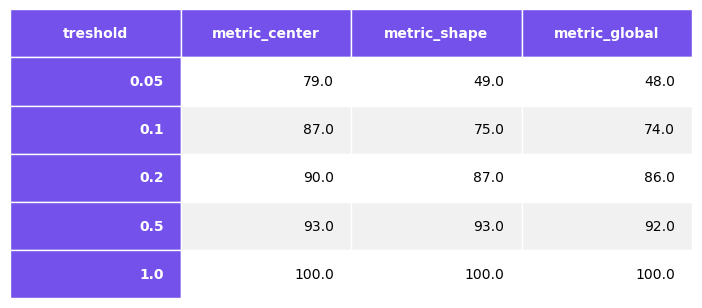

In [15]:
tresh = [0.05, 0.1, 0.2, 0.5, 1]
eval_result = {}
eval = pd.DataFrame()

for t in tresh:
    eval_custom["metric_center"] = False
    eval_custom["metric_shape"] = False

    # Pose des conditions
    # center_x
    cond_center_1 = eval_custom.annot_center_x > (eval_custom.yolo_center_x - t)
    cond_center_2 = eval_custom.annot_center_x < (eval_custom.yolo_center_x + t)
    # center_y
    cond_center_3 = eval_custom.annot_center_y > (eval_custom.yolo_center_y - t)
    cond_center_4 = eval_custom.annot_center_y < (eval_custom.yolo_center_y + t)
    # width
    cond_shape_1 = eval_custom.annot_width > (eval_custom.yolo_width - t)
    cond_shape_2 = eval_custom.annot_width < (eval_custom.yolo_width + t)
    # height
    cond_shape_3 = eval_custom.annot_height > (eval_custom.yolo_height - t)
    cond_shape_4 = eval_custom.annot_height < (eval_custom.yolo_height + t)

    # Calcul des métriques
    eval_custom["metric_center"][cond_center_1 & cond_center_2 & cond_center_3 & cond_center_4] = True 
    eval_custom["metric_shape"][cond_shape_1 & cond_shape_2 & cond_shape_3 & cond_shape_4] = True

    cond_center = eval_custom.metric_center == True
    cond_shape = eval_custom.metric_shape == True

    eval_result['treshold'] = t
    eval_result['metric_center'] = round(len(eval_custom[cond_center]) / len(eval_custom), 2) * 100
    eval_result['metric_shape'] = round(len(eval_custom[cond_shape]) / len(eval_custom), 2) * 100
    eval_result['metric_global'] = round(len(eval_custom[cond_center & cond_shape]) / len(eval_custom), 2) * 100

    eval_result = pd.Series(eval_result)
    eval = eval.append(eval_result, ignore_index=True)

eval = eval[['treshold', 'metric_center', 'metric_shape', 'metric_global']]
export_png_table(eval, filename='img/metrics_yolo_custom.png')

### 4-3-2. Métrique IoU (Intersection Over Union)

In [16]:
eval_iou = pd.merge(yolo_result, results, on='filename')
eval_iou['yolo_xmin'] = np.nan
eval_iou['yolo_ymin'] = np.nan
eval_iou['yolo_xmax'] = np.nan
eval_iou['yolo_ymax'] = np.nan
eval_iou["iou"] = np.nan

for i in range(len(eval_iou)):
    # Transformation des coordonnées relatives en coordonnées interprétables
    center_x = eval_iou['width'][i] * eval_iou['yolo_center_x'][i]
    center_y = eval_iou['height'][i] * eval_iou['yolo_center_y'][i]
    h_crop = eval_iou['height'][i] * eval_iou['yolo_height'][i]
    w_crop = eval_iou['width'][i] * eval_iou['yolo_width'][i]

    eval_iou['yolo_xmin'][i] = int(center_x - w_crop / 2)
    eval_iou['yolo_ymin'][i] = int(center_y - h_crop / 2)
    eval_iou['yolo_xmax'][i] = int(center_x + w_crop / 2)
    eval_iou['yolo_ymax'][i] = int(center_y + h_crop / 2)

    # Calcul des aires
    annot_area = (eval_iou['annot_xmax'][i] - eval_iou['annot_xmin'][i]) * (eval_iou['annot_ymax'][i] - eval_iou['annot_ymin'][i])
    yolo_area = (eval_iou['yolo_xmax'][i] - eval_iou['yolo_xmin'][i]) * (eval_iou['yolo_ymax'][i] - eval_iou['yolo_ymin'][i])

    overleap_xmin = max(eval_iou['annot_xmin'][i], eval_iou['yolo_xmin'][i])
    overleap_ymin = max(eval_iou['annot_ymin'][i], eval_iou['yolo_ymin'][i])
    overleap_xmax = min(eval_iou['annot_xmax'][i], eval_iou['yolo_xmax'][i])
    overleap_ymax = min(eval_iou['annot_ymax'][i], eval_iou['yolo_ymax'][i])
    overleap_area = (overleap_xmax - overleap_xmin) * (overleap_ymax - overleap_ymin)

    union_area = annot_area + yolo_area - overleap_area

    eval_iou['iou'][i] = overleap_area / union_area

eval_iou = eval_iou[eval_iou['iou'] != float('inf')]
eval_iou.head()

,filename,yolo_center_x,yolo_center_y,yolo_width,yolo_height,annot_xmax,annot_xmin,annot_ymax,annot_ymin,height,width,yolo_xmin,yolo_ymin,yolo_xmax,yolo_ymax,iou
0,n02085620_10074.jpg,0.455568,0.489279,0.804954,1.057105,276,25,498,10,500,333,17.0,-19.0,285.0,508.0,0.867258
1,n02085620_10131.jpg,0.548339,0.504275,0.855886,0.966300,393,49,493,9,495,395,47.0,10.0,385.0,488.0,0.959129
2,n02085620_10621.jpg,0.482755,0.502806,0.389775,0.703651,335,142,250,43,298,500,143.0,44.0,338.0,254.0,0.956541
3,n02085620_1073.jpg,0.488581,0.530515,0.992405,0.990712,312,0,498,27,500,345,-2.0,17.0,339.0,512.0,0.870595
4,n02085620_10976.jpg,0.517973,0.559173,0.490166,0.733000,242,90,452,104,484,322,87.0,93.0,245.0,448.0,0.922219


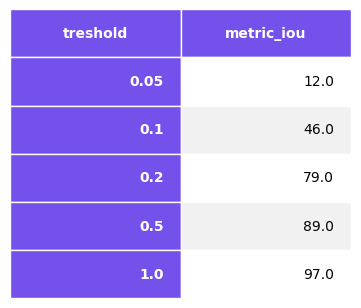

In [17]:
tresh = [0.05, 0.1, 0.2, 0.5, 1]
eval_result = {}
eval = pd.DataFrame()

for t in tresh:
    eval_iou["metric_iou"] = False   

    # Calcul des métriques
    eval_iou["metric_iou"][eval_iou['iou'] > (1 - t)] = True 


    eval_result['treshold'] = t
    eval_result['metric_iou'] = round(len(eval_iou[eval_iou.metric_iou == True]) / len(eval_iou), 2) * 100

    eval_result = pd.Series(eval_result)
    eval = eval.append(eval_result, ignore_index=True)

eval = eval[['treshold', 'metric_iou']]
export_png_table(eval, filename='img/metrics_yolo_iou.png')

In [18]:
ap = round(eval_iou.iou.mean() * 100, 1)
print(f"YOLOv4 a une précision moyenne de {ap} % sur l'ensemble du jeu de données.")

YOLOv4 a une précision moyenne de 78.7 % sur l'ensemble du jeu de données.


### 4-3-3. Conclusion sur les métriques
En fonction du seuil d'erreur, YOLOv4 joue bien son rôle d'identificateur d'objet. Comme pour le classifieur, la précision pourrait être significativement amélioré en même temps que la qualité du jeu de données, car nous l'avons vu, il peut y avoir plusieurs chiens dans une photo.